In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds

In [2]:
data = BinaryIV.generate_data_rolling_ate(N_simulations=2)

In [4]:
binaryIV = BinaryIV('IV Dag', data)

algorihtms = binaryIV.get_algorithms('ATE')
runtimes = binaryIV.run_all_bounding_algorithms()

Running ATE_2SLS_0.99...
ATE_2SLS_0.99 completed in 0.07 seconds.
Running ATE_2SLS_0.98...
ATE_2SLS_0.98 completed in 0.04 seconds.
Running ATE_causaloptim...
ATE_causaloptim completed in 2.20 seconds.
Running PNS_causaloptim...
PNS_causaloptim completed in 1.69 seconds.
Running ATE_autobound...
ATE_autobound completed in 0.60 seconds.
Running PNS_autobound...
PNS_autobound completed in 0.50 seconds.
Running ATE_entropybounds_0.80...
ATE_entropybounds_0.80 completed in 0.11 seconds.
Running ATE_entropybounds_0.20...
ATE_entropybounds_0.20 completed in 0.11 seconds.
Running ATE_entropybounds_0.10...
ATE_entropybounds_0.10 completed in 0.11 seconds.
Running PNS_entropybounds_0.80...
PNS_entropybounds_0.80 completed in 0.06 seconds.
Running PNS_entropybounds_0.20...
PNS_entropybounds_0.20 completed in 0.07 seconds.
Running PNS_entropybounds_0.10...
PNS_entropybounds_0.10 completed in 0.09 seconds.
Running ATE_zaffalonbounds...
ATE_zaffalonbounds completed in 19.18 seconds.
Running PNS_zaf

Algorithm: ATE_2SLS_0.99
  Fail Rate: 0.00%
  Invalid Rate: 0.00%
  Net Bound Width: 1.1004946959296134
Algorithm: ATE_2SLS_0.98
  Fail Rate: 0.00%
  Invalid Rate: 0.00%
  Net Bound Width: 0.9976650097391802
Algorithm: ATE_causaloptim
  Fail Rate: 0.00%
  Invalid Rate: 0.00%
  Net Bound Width: 0.7834378957545349
Algorithm: PNS_causaloptim
  Fail Rate: 0.00%
  Invalid Rate: 0.00%
  Net Bound Width: 0.2869927368201952
Algorithm: ATE_autobound
  Fail Rate: 0.00%
  Invalid Rate: 0.00%
  Net Bound Width: 0.7878221534013765
Algorithm: PNS_autobound
  Fail Rate: 0.00%
  Invalid Rate: 0.00%
  Net Bound Width: 0.36450609281825247
Algorithm: ATE_entropybounds_0.80
  Fail Rate: 0.00%
  Invalid Rate: 50.00%
  Net Bound Width: 0.9999757142291291
Algorithm: ATE_entropybounds_0.20
  Fail Rate: 0.00%
  Invalid Rate: 50.00%
  Net Bound Width: 0.8971388796796597
Algorithm: ATE_entropybounds_0.10
  Fail Rate: 0.00%
  Invalid Rate: 50.00%
  Net Bound Width: 0.6949311330268106
Algorithm: PNS_entropybounds_

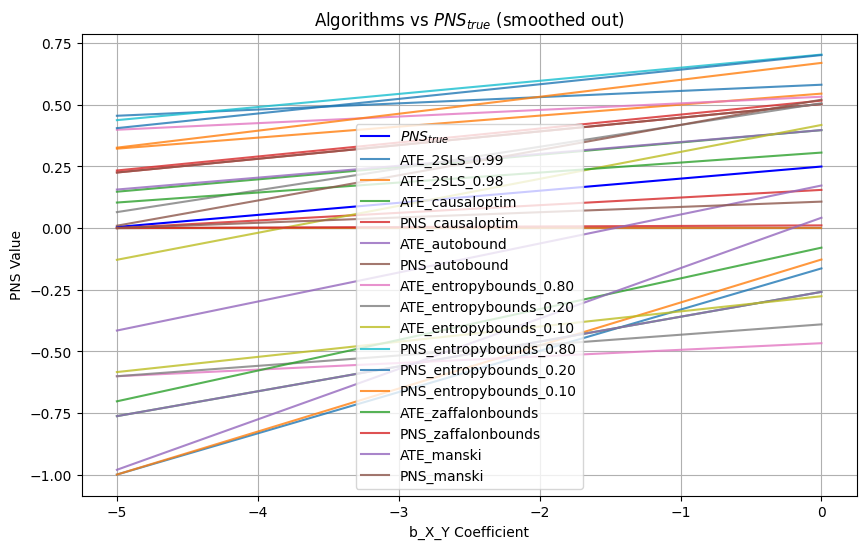

In [6]:
algorithms = list(runtimes['runtimes'].keys())
PlottingUtil.print_bound_statistics(binaryIV.data, algorithms)
PlottingUtil.plot_smoothed_query_vs_bounds(binaryIV.data, 'PNS', algorithms, 1)

In [24]:
invalids = binaryIV.data[binaryIV.data['causaloptim_bound_valid'] == False]
invalIV = BinaryIV('IV Dag', invalids)
invalIV.bound_ate_causaloptim()
invalIV.data

KeyError: 'causaloptim_bound_valid'

In [7]:
binaryIV.data

,seed,intercept_X,intercept_Y,b_Z,b_U_X,b_X_Y,b_U_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,p_U,p_Z,Z,U,X,Y,entropy_Z,entropy_U,entropy_X,entropy_Y,ATE_2SLS_0.99_bound_lower,ATE_2SLS_0.99_bound_upper,ATE_2SLS_0.99_bound_valid,ATE_2SLS_0.99_bound_width,ATE_2SLS_0.99_bound_failed,ATE_2SLS_0.98_bound_lower,ATE_2SLS_0.98_bound_upper,ATE_2SLS_0.98_bound_valid,ATE_2SLS_0.98_bound_width,ATE_2SLS_0.98_bound_failed,ATE_causaloptim_bound_lower,ATE_causaloptim_bound_upper,ATE_causaloptim_bound_valid,ATE_causaloptim_bound_width,ATE_causaloptim_bound_failed,PNS_causaloptim_bound_lower,PNS_causaloptim_bound_upper,PNS_causaloptim_bound_valid,PNS_causaloptim_bound_width,PNS_causaloptim_bound_failed,ATE_autobound_bound_lower,ATE_autobound_bound_upper,ATE_autobound_bound_valid,ATE_autobound_bound_width,ATE_autobound_bound_failed,PNS_autobound_bound_lower,PNS_autobound_bound_upper,PNS_autobound_bound_valid,PNS_autobound_bound_width,PNS_autobound_bound_failed,ATE_entropybounds_0.80_bound_lower,ATE_entropybounds_0.80_bound_upper,ATE_entropybounds_0.80_bound_valid,ATE_entropybounds_0.80_bound_width,ATE_entropybounds_0.80_bound_failed,ATE_entropybounds_0.20_bound_lower,ATE_entropybounds_0.20_bound_upper,ATE_entropybounds_0.20_bound_valid,ATE_entropybounds_0.20_bound_width,ATE_entropybounds_0.20_bound_failed,ATE_entropybounds_0.10_bound_lower,ATE_entropybounds_0.10_bound_upper,ATE_entropybounds_0.10_bound_valid,ATE_entropybounds_0.10_bound_width,ATE_entropybounds_0.10_bound_failed,PNS_entropybounds_0.80_bound_lower,PNS_entropybounds_0.80_bound_upper,PNS_entropybounds_0.80_bound_valid,PNS_entropybounds_0.80_bound_width,PNS_entropybounds_0.80_bound_failed,PNS_entropybounds_0.20_bound_lower,PNS_entropybounds_0.20_bound_upper,PNS_entropybounds_0.20_bound_valid,PNS_entropybounds_0.20_bound_width,PNS_entropybounds_0.20_bound_failed,PNS_entropybounds_0.10_bound_lower,PNS_entropybounds_0.10_bound_upper,PNS_entropybounds_0.10_bound_valid,PNS_entropybounds_0.10_bound_width,PNS_entropybounds_0.10_bound_failed,ATE_zaffalonbounds_bound_lower,ATE_zaffalonbounds_bound_upper,ATE_zaffalonbounds_bound_valid,ATE_zaffalonbounds_bound_width,ATE_zaffalonbounds_bound_failed,PNS_zaffalonbounds_bound_lower,PNS_zaffalonbounds_bound_upper,PNS_zaffalonbounds_bound_valid,PNS_zaffalonbounds_bound_width,PNS_zaffalonbounds_bound_failed,ATE_manski_bound_lower,ATE_manski_bound_upper,ATE_manski_bound_width,ATE_manski_bound_failed,ATE_manski_bound_valid,PNS_manski_bound_lower,PNS_manski_bound_upper,PNS_manski_bound_width,PNS_manski_bound_failed,PNS_manski_bound_valid
0,866034,0,0,-0.262467,-1.262984,-5.0,0.825349,-0.655176,0.004444,0.014015,0.669191,0.861371,0.742232,"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, ...","[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...",0.835666,0.568307,0.733767,0.988149,-1.000000,0.455757,True,1.455757,False,-1.000000,0.322277,True,1.322277,False,-0.762943,0.147692,True,0.910635,False,0.000000,0.225564,True,0.225564,False,-0.762943,0.156461,True,0.919403,False,-0.0,0.225564,True,0.225564,False,-0.601000,0.399001,False,1.000001,False,-0.601000,0.064899,False,0.665899,False,-0.584047,-0.128591,False,0.455456,False,0.0,0.437997,True,0.437997,False,3.540999e-07,0.405555,True,0.405555,False,0.000000e+00,0.326344,True,0.326344,False,-0.7028,0.1037,True,0.8065,False,0.000,0.2338,True,0.2338,False,-0.980583,-0.415617,0.564965,False,True,0.000000,0.009709,0.009709,False,True
1,888429,0,0,1.382871,-2.245376,0.0,0.066512,0.000000,0.249788,0.512732,0.512732,0.745821,0.706355,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, ...","[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...",0.868721,0.784919,0.959442,0.998846,-0.163517,0.581715,True,0.745232,False,-0.127428,0.545625,True,0.673053,False,-0.258766,0.397475,True,0.656241,False,0.155027,0.503448,True,0.348422,Fa